# Векторные представления текстов

Сравните использование CBoW-представления (сумму векторов слов) с BoW и Tf-IDF представлением на задаче сентимент-анализа. Использовать линейный классификатор. Определить, какие слова наиболее влияют на исход в рамках линейной модели. Как это сделать в BoW-модели и CBoW-модели?

In [103]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.models import Word2Vec, KeyedVectors

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

### IMDB (Internet Movie Database) обзоры фильмов для анализа настроений

In [104]:
df = pd.read_csv('imdb_master.csv')
df.head()

,number,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [105]:
print(f"Labels type: {np.unique(df['label'])}")
print(f"Unsup count: {len(df[df['label'] == 'unsup'])}")

Labels type: ['neg' 'pos' 'unsup']
Unsup count: 50000


In [106]:
df['label'] = df['label'].map({'neg': 0, 'pos': 1, 'unsup': -1})

In [107]:
train = df.loc[df['type'] == 'train']
test = df.loc[df['type'] == 'test']

X_train_vec = train['review']
y_train_vec = train['label']

X_test = test['review']
y_test = test['label']

In [108]:
stopwords_eng = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def cleaning(text):
    text = text.lower()
    text = re.sub('[^a-z]', ' ', text)
    words = [lemmatizer.lemmatize(word) for word in text.split()]
    return [word for word in words if word not in stopwords_eng]

In [109]:
%time X_train_vec = X_train_vec.apply(cleaning)
%time X_test = X_test.apply(cleaning)

CPU times: user 1min 2s, sys: 115 ms, total: 1min 2s
Wall time: 1min 2s
CPU times: user 19 s, sys: 107 ms, total: 19.1 s
Wall time: 19.1 s


In [110]:
X_train = X_train_vec[y_train_vec != -1]
y_train = y_train_vec[y_train_vec != -1]

In [111]:
print(f"Without unsup label: {X_train.shape, X_test.shape}")

Without unsup label: ((25000,), (25000,))


In [112]:
X_train, X_test, y_train, y_test = train_test_split(X_train.append(X_test), y_train.append(y_test), \
                                                    test_size=0.2, random_state=1709)

In [113]:
print(f"Without unsup label: {X_train.shape, X_test.shape}")

Without unsup label: ((40000,), (10000,))


In [114]:
np.random.seed(1709)
list(X_train.sample(1))

[['description',
  'corny',
  'utterly',
  'stupid',
  'worthless',
  'cheap',
  'lame',
  'make',
  'wonder',
  'abnormally',
  'dumb',
  'people',
  'even',
  'wasted',
  'month',
  'spend',
  'budget',
  'guessing',
  'probably',
  'dollar',
  'make',
  'movie',
  'wa',
  'hysterical',
  'watch',
  'without',
  'mystery',
  'science',
  'theater',
  'giving',
  'best',
  'advice',
  'world',
  'br',
  'br',
  'spare',
  'spare',
  'time',
  'life',
  'money',
  'repeat',
  'even',
  'ponder',
  'whether',
  'see',
  'movie',
  'movie',
  'corny',
  'make',
  'face',
  'turn',
  'purple',
  'outraged',
  'boredom',
  'one',
  'digit',
  'iq',
  'guest',
  'watch',
  'absolutely',
  'despicable',
  'movie',
  'might',
  'actually',
  'admire',
  'like',
  'said',
  'one',
  'digit',
  'iq',
  'br',
  'br',
  'actor',
  'puppet',
  'bought',
  'garage',
  'sale',
  'course',
  'camera',
  'music',
  'gaurentee',
  'make',
  'slightly',
  'entertaining',
  'home',
  'video',
  'piece',


### BoW (Bag of words)

In [115]:
bow_vectorizer = CountVectorizer()
bow_train = bow_vectorizer.fit_transform(X_train.apply(lambda x: " ".join(x)))
bow_test = bow_vectorizer.transform(X_test.apply(lambda x: " ".join(x)))

In [116]:
bow_train.shape, bow_test.shape

((40000, 81497), (10000, 81497))

In [134]:
model = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000)
model.fit(bow_train, y_train)

print(f"Score: {model.score(bow_test, y_test)}")

Score: 0.8852


### TF-IDF

In [118]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_train = tfidf_vectorizer.fit_transform(X_train.apply(lambda x: " ".join(x)))
tfidf_test = tfidf_vectorizer.transform(X_test.apply(lambda x: " ".join(x)))

In [119]:
tfidf_train.shape, tfidf_test.shape

((40000, 81497), (10000, 81497))

In [120]:
model = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000)
model.fit(tfidf_train, y_train)

print(f"Score: {model.score(tfidf_test, y_test)}")

Score: 0.8966


### CBoW (Continuous Bag of Words) model

In [121]:
%time model = Word2Vec(X_train_vec, window=10, workers=4)

CPU times: user 2min 29s, sys: 622 ms, total: 2min 30s
Wall time: 54.5 s


In [122]:
word_vectors = model.wv
print(f'Words count: {len(word_vectors.vocab)}')

Words count: 41758


In [123]:
word_vectors.most_similar("girl")

[('boy', 0.7207902669906616),
 ('virgin', 0.6572047472000122),
 ('woman', 0.6218031048774719),
 ('gal', 0.6111984848976135),
 ('teenage', 0.584984302520752),
 ('cheerleader', 0.5686829090118408),
 ('lad', 0.5591179132461548),
 ('slut', 0.5567667484283447),
 ('stripper', 0.5564807653427124),
 ('teenager', 0.5460202097892761)]

In [124]:
word_vectors.most_similar("anime")

[('manga', 0.7538653016090393),
 ('animated', 0.6695896983146667),
 ('ff', 0.6604626178741455),
 ('animation', 0.6538820862770081),
 ('gundam', 0.6467862129211426),
 ('cartoon', 0.6370406746864319),
 ('dragonball', 0.6304785013198853),
 ('pokemon', 0.6280137896537781),
 ('naruto', 0.611329197883606),
 ('elfen', 0.604460597038269)]

In [125]:
def to_cbow(model, tokenized_texts, word_set=None, word_weights=None, normalize=False, average=False):
    result = []
    assert bool(word_set) == bool(word_weights)
    
    for tokens in tokenized_texts:
        if word_set:
            tokens = [t for t in tokens if t in word_set]

        # word in model.vocab - это условие можно убрать для fasttext моделей, у которых есть обработка подслов
        word_vectors = np.array([model[word] for word in tokens if word in model.vocab])
        if word_weights:
            token_weights = np.array([word_weights[w] for w in tokens if w in model.vocab])
            text_vector = np.dot(token_weights, word_vectors)
        else:
            text_vector = word_vectors.sum(axis=0)
        if normalize:
            norm = np.linalg.norm(text_vector)
            if norm > 1e-8:
                text_vector /= np.linalg.norm(text_vector)
        elif average:
            text_vector /= len(tokens)
        result.append(text_vector)
        
    return np.array(result)

In [126]:
cbow_train = to_cbow(word_vectors, X_train.values.tolist())
cbow_test = to_cbow(word_vectors, X_test.values.tolist())

In [127]:
model = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=2000)
model.fit(cbow_train, y_train)

print(f"Score: {model.score(cbow_test, y_test)}")

Score: 0.8623


In [128]:
def tsne_plot(model, words):
    labels = []
    tokens = []

    for word in words:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(init='pca', random_state=1709, metric='cosine', n_iter=2500)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20, 15)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2),
                     textcoords='offset points', size=18)
        
    plt.show()

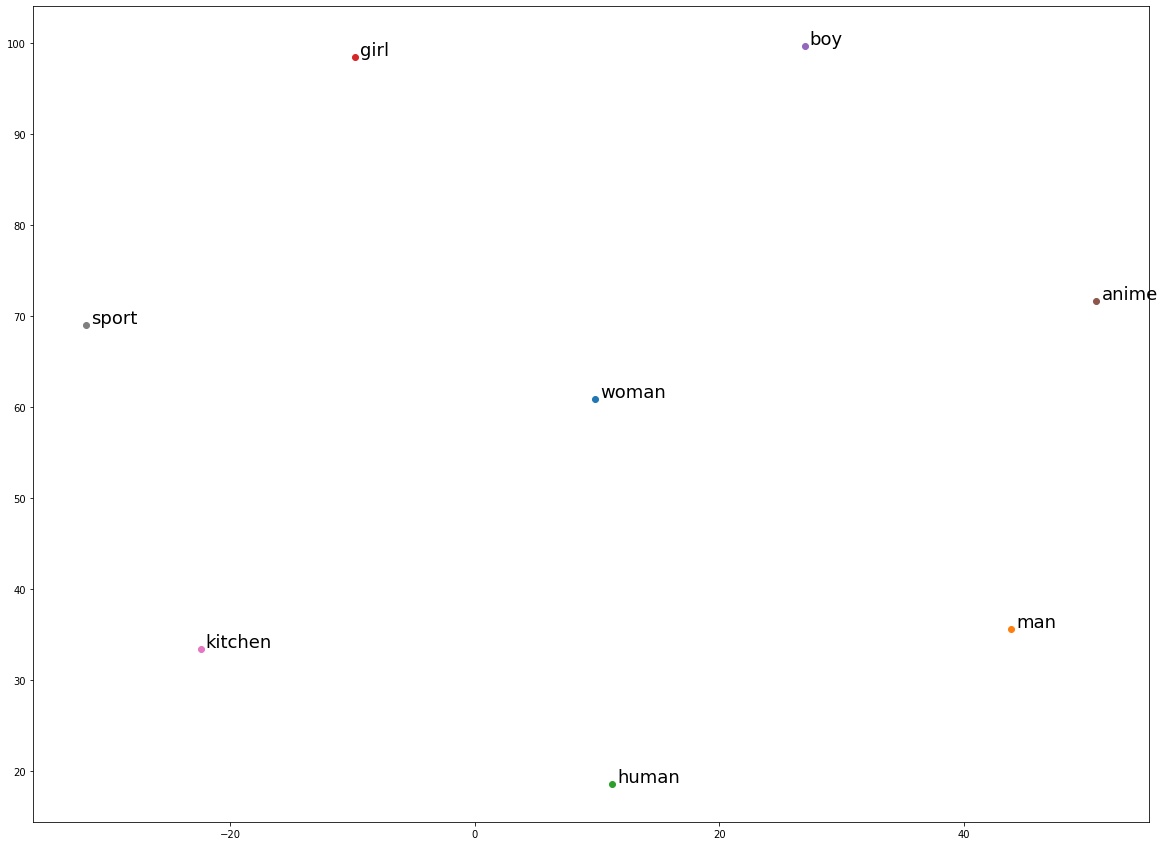

In [129]:
tsne_plot(word_vectors, [
    'woman', 'man', 'human',
    'girl', 'boy', 'anime',
    'kitchen', 'sport', 
])